rm: __pycache__/: No such file or directory

LSPI(alpha_a=0.25, alpha_b=0.75,eps_a=1.00, eps_b=0.25 rep 0...

LSPI(alpha_a=0.25, alpha_b=0.75,eps_a=1.00, eps_b=0.25 rep 1...

LSPI(alpha_a=0.25, alpha_b=0.75,eps_a=1.00, eps_b=0.25 rep 2...

LSPI(alpha_a=0.25, alpha_b=0.75,eps_a=1.00, eps_b=0.25 rep 3...

LSPI(alpha_a=0.25, alpha_b=0.75,eps_a=1.00, eps_b=0.25 rep 4...
Executed 5 algorithm reps in 50.2498 seconds.

Best VFA (1st) test... EETDR CI: -137.8 +/- 12.4

Best VFA (2nd) test... EETDR CI: -137.8 +/- 12.4

Best VFA (3rd) test... EETDR CI: -137.8 +/- 12.4

Best VFA (4th) test... EETDR CI: -137.8 +/- 12.4

Best VFA (5th) test... EETDR CI: -137.8 +/- 12.4

Best VFA (6th) test... EETDR CI: -137.9 +/- 19.1

Best VFA (7th) test... EETDR CI: -140.7 +/- 20.2

Best VFA (8th) test... EETDR CI: -138.4 +/- 19.8

Best VFA (9th) test... EETDR CI: -175.4 +/- 27.4

Best VFA (10th) test... EETDR CI: -186.3 +/- 35.7

Best VFA (1st) test... EETDR CI: -137.8 +/- 12.4

Best VFA (2nd) test... EETDR CI: 

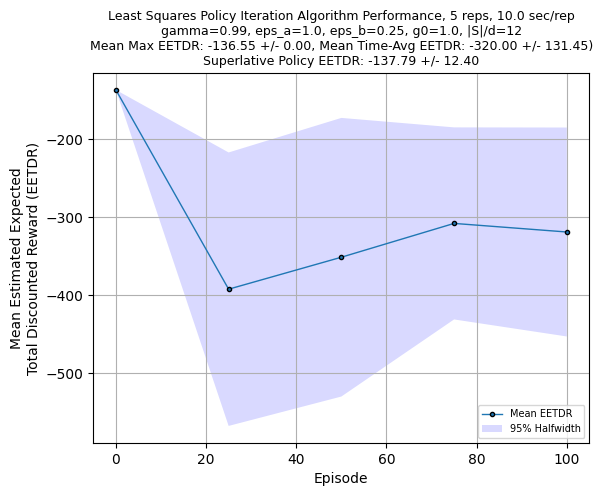

In [23]:
!rm -r __pycache__/
from support_functions import MDPBase

import numpy as np
from time import perf_counter

class LSPI(MDPBase):
    """Least-Squares Policy Iteration (LSPI) algorithm for reinforcement learning.

    Additional Attributes:
        eta (float): The regularization parameter for the least-squares update, default is 1e-6.
        mem_buffer_size (int): The size of the memory experience replay buffer, default is 2048.
        n_batch_size (int): The number of experiences needed to perform a batch update of the 
                value-function approximation, default is 512.
        num_state_dims (int): The number of dimensions in the state space of the environment.

    Args:
        env: The environment in which the agent will be trained.
        **kwargs: Additional keyword arguments for algorithm-specific parameters.
    """
    name = "Least Squares Policy Iteration"

    def __init__(self, env, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name     = self.name
        self.eta                = kwargs.get('eta',1e-6)                # regularization parameter
        self.mem_buffer_size    = kwargs.get('mem_buffer_size', 2**11)  # experience replay buffer
        self.n_batch_size       = kwargs.get('n_batch_size', 2**9)      # num exps batch update
        self.num_state_dims     = len(env.observation_space.low)        # state space dims
        self.best_scores = [{'ETDR': -np.inf, 'ETDR_hw': np.inf, 'w': None}
                            for _ in range(self.num_best_scores)]

        """ Tunable Hyperparameters with new defaults"""
        self.alpha_a    = kwargs.get('alpha_a',0.25)    # Learning Rate
        self.alpha_b    = kwargs.get('alpha_b',0.75)    # Learning Rate
        self.eps_a      = kwargs.get('eps_a',1.0)       # Eps-Greedy stepsize rule
        self.eps_b      = kwargs.get('eps_b',0.25)      # Eps-Greedy stepsize rule
        self.qinit      = kwargs.get('qinit',1.0)
        self.gamma      = kwargs.get('gamma',0.99)      # discount rate

    #@override(MDPBase) # Needs Python >3.12
    def phi(self,s,a):
        sa = np.hstack(((s-self.Slow)/self.Srange,((s-self.Slow)/self.Srange)**2,a-1))
        sa2 = np.matrix(sa).T*np.matrix(sa)
        up_tri_sa2 = np.triu(sa2)
        sa2_flat = up_tri_sa2[np.triu_indices_from(up_tri_sa2)]
        return np.hstack((1, sa, sa2_flat))

    def batchPhi(self,s_batch,a_batch):
        return np.array([self.phi(s, a) for s, a in zip(s_batch, a_batch)])

    def Qbar(self,s,a,w):
        return np.dot(w,self.phi(s,a))

    def batchArgmaxQbar(self,s_arrays, w):
        # Compute Qvals for each combination of s and a
        Qvals = np.array([[self.Qbar(s, a, w) for a in range(self.num_actions)] for s in s_arrays])
        # Find the maximum value for each row (i.e., each s array)
        max_actions = np.argmin(Qvals, axis=1)
        #max_actions = np.argmax(Qvals, axis=1)
        return max_actions

    def argmaxQbar(self,s,w):
        Qvals = [self.Qbar(s,a,w) for a in range(self.num_actions)]
        return np.argmin(Qvals)
        return np.argmax(Qvals)
    
    #@override(MDPBase)
    def update_best_scores(self, mean, hw, w):
    # Find the first score that mean is greater than 
        for i in range(len(self.best_scores)):
            if mean-hw > self.best_scores[i]['ETDR'] - self.best_scores[i]['ETDR_hw']:
                # Shift scores and parameters
                self.best_scores.insert(i, {'ETDR': np.copy(mean), 'ETDR_hw': np.copy(hw), 
                                       'w': np.copy(w)})
                self.best_scores.pop()   # Remove least best score
                return True
        return False

    #@override(MDPBase) # Needs Python >3.12
    def evaluate_policy(self, w, num_reps, seed_mult=1):
        # initialize_test_data_structure
        test_data = np.zeros((num_reps))
        # run num_test_reps replication per test
        for rep in range(num_reps):
            # initialize episode conditions
            terminated = False
            truncated = False
            # Initialize episode reward
            Gtest = 0
            # Initialize the system by resetting the environment, obtain state var
            state = self.env.reset(seed=seed_mult*1000+rep)[0]
            while not (terminated or truncated):
                # select action with highest q-value
                action = self.argmaxQbar(state,w)
                # apply action and observe system information
                state, reward, terminated, truncated, _ = self.env.step(action)
                # update episode cumulative reward
                Gtest += reward
            test_data[rep] = Gtest
        mean, hw = self.confinterval(test_data)
        return mean, hw

    #@override(MDPBase) # Needs Python >3.12
    def find_superlative(self, num_test_reps=30):
        # initialize list of means and half-widths for testing top policies
        mean_values, hw_values = [], []
        # loop through top policies stored in best_scores to find superlative policy
        for i, score in enumerate(self.best_scores):
            mean, hw = self.evaluate_policy(score['w'], num_test_reps, 2)
            print(f"\nBest VFA ({self.ordinal(i+1)}) test... EETDR CI: {mean:>6.1f} +/- {hw:4.1f}")
            mean_values.append(mean)
            hw_values.append(hw)
        # determine superlative policy and record its mean and half-width
        indBestCILB = np.argmax(np.array(mean_values)-np.array(hw_values))
        maxETDR = mean_values[indBestCILB]
        maxETDRhw = hw_values[indBestCILB]
        return indBestCILB, maxETDR, maxETDRhw

    def train(self, num_replications, num_episodes, verbose=False):
        time_start = perf_counter()
        num_features = len(self.phi(self.env.reset()[0],0))  # number features

        for z in range(num_replications):
            mem_buffer_counter = 0  # initialize memory replay buffer counter
            # initialize tuple memory buffer components
            mem_buffer_states = np.zeros((self.mem_buffer_size, self.num_state_dims),
                                         dtype=np.float32)
            mem_buffer_next_states = np.zeros((self.mem_buffer_size, self.num_state_dims),
                                              dtype=np.float32)
            mem_buffer_actions = np.zeros(self.mem_buffer_size, dtype=np.int32)
            mem_buffer_rewards = np.zeros(self.mem_buffer_size, dtype=np.float32)
            mem_buffer_done_flags = np.zeros(self.mem_buffer_size, dtype=np.int32)

            # initialize theta vector of basis function weights
            w = np.zeros(num_features)

            print(f"\nLSPI(alpha_a={self.alpha_a:<3.2f}, alpha_b={self.alpha_b:<3.2f},"
                + f"eps_a={self.eps_a:<3.2f}, eps_b={self.eps_b:<3.2f} rep {z}...")

            for m in range(num_episodes): # M
                np.random.seed(int(m + 1e6*z + 1e5*self.offset))    # Set rng seed
                state = self.env.reset(seed=int(z + 1e6 + m + 1e5*self.offset))[0]
                terminated,truncated = False,False                  # Episode complete flags
                G = 0                                               # Episode reward

                # LSPI main loop, implementing trajectory following state sampling
                while not(terminated or truncated):
                    # select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(m):      # With probability epsilon:
                        action = self.argmaxQbar(state,w)       # Act greedy, using Qbar
                    else:
                        action = self.env.action_space.sample() # Act randomly to explore

                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    G += reward                     # Update episode cumulative reward
                    state = np.copy(next_state)     # Update state

                    # store unite experience in memory replay buffer, increment counter 
                    index = mem_buffer_counter % self.mem_buffer_size 
                    mem_buffer_states[index, :] = state 
                    mem_buffer_actions[index] = action 
                    mem_buffer_rewards[index] = reward 
                    mem_buffer_next_states[index, :] = next_state 
                    mem_buffer_done_flags[index] = terminated 
                    mem_buffer_counter += 1

                # update policy -- select n_batch_size experiences and w solving regression problem
                if mem_buffer_counter >= self.n_batch_size:
                    # sample memory buffer, collecting a batch of SARnSd transitions
                    # determine indexes of experiences used to update policy 
                    max_memory = min(self.mem_buffer_size, mem_buffer_counter)
                    batch_indexes = np.random.choice(np.arange(max_memory), self.n_batch_size, 
                                                     replace=False)

                    # specify batches
                    states_batch = mem_buffer_states[batch_indexes, :]
                    actions_batch = mem_buffer_actions[batch_indexes] 
                    rewards_batch = mem_buffer_rewards[batch_indexes] 
                    next_states_batch = mem_buffer_next_states[batch_indexes, :]
                    done_flags_batch = mem_buffer_done_flags[batch_indexes]

                    # compute matrices and vectors for normal equation
                    Phi_curr = np.matrix(self.batchPhi(states_batch, actions_batch))
                    next_actions_batch = self.batchArgmaxQbar(next_states_batch, w)
                    Phi_next = np.matrix(self.batchPhi(next_states_batch, next_actions_batch))
                    r = np.matrix(rewards_batch).T
                    # ensure terminal state-action pairs have zero value
                    Phi_next[done_flags_batch==1,1:] = 0
                    # determine w by solving normal equation with L2 regularization 
                    what = np.ravel(np.linalg.solve(Phi_curr.T*(Phi_curr-self.gamma*Phi_next)
                                                    +self.eta*np.eye(Phi_curr.shape[1]), Phi_curr.T*r))
                    #                                +self.eta, Phi_curr.T*r))
                    #+self.eta*np.eye(Phi_curr.shape[0]), Phi_curr.T*r))
                    #what = np.ravel(np.linalg.lstsq(Phi_curr.T*(Phi_curr-self.gamma*Phi_next)
                    #                                +self.eta, Phi_curr.T*r)[0])
                    # Polyak averaging
                    w = (1-self.alpha(m))*w + self.alpha(m)*what

                if verbose: print(f"In Episode: {m}, Cumulative reward: {G}")
                self.Gzm.append((z,G))

                # test current policy (as represented by current Q) every test_freq episodes
                if m % self.test_freq == 0:
                    mean, hw = self.evaluate_policy(w, self.num_test_reps)
                    self.GzmTest.append((z, m, mean, hw))

                    # update best scores if necessary
                    if verbose:
                        self.update_and_print(m, mean, hw, w)
                    else:
                        self.update_best_scores(mean, hw, w)

            # last test of current algorithm replication
            mean, hw = self.evaluate_policy(w, self.num_test_reps)
            self.GzmTest.append((z, num_episodes, mean, hw))

            # update best EETDR scores if necessary
            if verbose:
                self.update_and_print(num_episodes, mean, hw, w)
            else:
                self.update_best_scores(mean, hw, w)

        time_elapsed = perf_counter() - time_start
        print(f"Executed {num_replications} algorithm reps in {time_elapsed:0.4f} seconds.")

        self.total_training_reps += num_replications
        self.total_episodes += num_episodes
        # Update execution time record
        total_time = (self.total_training_reps * self.avg_execution_time) + time_elapsed
        self.avg_execution_time = total_time / self.total_training_reps


import gymnasium as gym

#env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')
lspi = LSPI(env)
lspi.train(num_replications=5, num_episodes=100)
lspi.get_results()
lspi.show_results()


Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 0...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 1...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 2...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 3...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 4...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 5...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 6...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, rep 7...
IHT full, starting to allow collisions

Semi-grad 4-step SARSA(alpha_a=

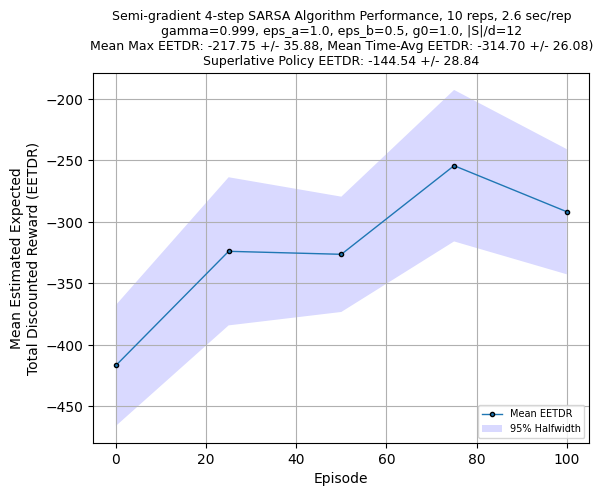

In [2]:
!rm -r __pycache__/
from support_functions import MDP_Tiled

import numpy as np
from time import perf_counter
from tiles3 import IHT
import collections

class SemiGradSARSA(MDP_Tiled):
    name = "Semi-gradient n-step SARSA"

    def __init__(self, env, n=1, **kwargs) -> None:
        super().__init__(env, max_size = 2**8, **kwargs)
        self.algorithm_name = f"Semi-gradient {n}-step SARSA"
        self.nm1 = n-1

    def train(self, num_replications, num_episodes, verbose=False):
        time_start = perf_counter()
        for z in range(num_replications):
            # theta vector of basis function weights
            w = self.qinit*np.ones((self.max_size,1))/self.num_tiles
            C = np.zeros((self.max_size,1))     # eligibility trace vector
            iht_VFA = IHT(self.max_size)        # integer hash table

            print(f"\nSemi-grad {self.nm1+1}-step SARSA("
                 +f"alpha_a={self.alpha_a:<3.2f},alpha_b={self.alpha_b:<3.2f},"
                 +f"eps_a={self.eps_a:<3.2f},eps_b={self.eps_b:<3.2f}, rep {z}...")

            for m in range(num_episodes): # M
                terminated,truncated = False,False                  # Episode complete flags
                Gm = 0                                              # Episode reward
                np.random.seed(int(m + 1e6*z + 1e5*self.offset))    # Set rng seed
                state = self.env.reset(seed=int(z + 1e6 + m + 1e5*self.offset))[0]
                state_queue = collections.deque([state])            # State record array

                # select action based on epsilon-greedy exploration mechanism
                if np.random.rand() > self.epsilon(m):          # With probability epsilon:
                    action = self.argmaxQbar(state, w, iht_VFA) # Act greedy, using Qbar
                else:
                    action = self.env.action_space.sample()     # Act randomly to explore

                action_queue = collections.deque([action])      # Action array, record of actions
                reward_queue = collections.deque([])            # Reward array, record of rewards

                # SARSA main loop (first nm1 transitions)
                for _ in range(self.nm1):
                    # Apply action and observe system information 
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    state_queue.append(next_state)      # Append next state to state array
                    reward_queue.append(reward)         # Append reward to reward array
                    Gm += reward                        # Update episode cumulative reward

                    # select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(m):              # With probability epsilon:
                        next_action = self.argmaxQbar(state,w,iht_VFA)  # Act greedy, using Qbar
                    else:
                        next_action = self.env.action_space.sample()    # Act randomly to explore
                    action_queue.append(next_action)

                # SARSA main loop (> first mm1 transitions until end of episode 
                while not(terminated or truncated):
                    # apply action and observe system information 
                    next_state, reward, terminated, truncated, _ = self.env.step(action_queue[-1])
                    state_queue.append(next_state)      # Append next state to state array
                    reward_queue.append(reward)         # Append reward to reward array
                    Gm += reward                        # Update episode cumulative reward

                    # select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(m):              # With probability epsilon:
                        next_action = self.argmaxQbar(state,w,iht_VFA)  # Act greedy, using Qbar
                    else:
                        next_action = self.env.action_space.sample()    # Act randomly to explore
                    action_queue.append(next_action)

                    # Temporal-Difference learning mechanism
                    qhat = (np.dot(reward_queue,self.gamma**np.array(range(len(reward_queue)))) 
                            + (1-terminated)*self.gamma**len(reward_queue)
                            *self.Qbar(next_state,next_action,w,iht_VFA))
                    Δ = qhat - self.Qbar(state_queue[0],action_queue[0],w,iht_VFA)  # TD error

                    # Update w vector
                    active_tiles = self.gradQbar(state_queue[0],action_queue[0],iht_VFA)
                    C[active_tiles] += 1 # update state-action counter 
                    w[active_tiles] += self.alpha(C[active_tiles])*Δ

                    state_queue.popleft()   #
                    action_queue.popleft()  # update by removing oldest values
                    reward_queue.popleft()  #

                # SARSA main loop (episode complete, updates from last nm1 transitions)
                while len(reward_queue)>0:
                    # Temporal Difference learning mechanism
                    qhat = np.dot(reward_queue, self.gamma**np.array(range(len(reward_queue))) )
                    Δ = qhat - self.Qbar(state_queue[0],action_queue[0],w,iht_VFA)  # TD error

                    # Update w vector
                    active_tiles = self.gradQbar(state_queue[0], action_queue[0],iht_VFA)
                    C[active_tiles] += 1 # update state-action counter 
                    w[active_tiles] += self.alpha(C[active_tiles])*Δ

                    # update state, action, and reward arrays by removing oldest values
                    state_queue.popleft()   #
                    action_queue.popleft()  # update by removing oldest values
                    reward_queue.popleft()  #

                if verbose: print(f"In Episode: {m}, Cumulative reward: {Gm}")
                self.Gzm.append((z,Gm))

                # test current policy (as represented by current Q) every test_freq episodes
                if m % self.test_freq == 0:
                    mean, hw = self.evaluate_policy(w, iht_VFA, self.num_test_reps)
                    self.GzmTest.append((z, m, mean, hw))

                    # update best scores if necessary
                    if verbose:
                        self.update_and_print(m, mean, hw, w, iht_VFA)
                    else:
                        self.update_best_scores(mean, hw, w, iht_VFA)

            # last test of current algorithm replication
            mean, hw = self.evaluate_policy(w, iht_VFA, self.num_test_reps)
            self.GzmTest.append((z, num_episodes, mean, hw))

            # update best EETDR scores if necessary
            if verbose:
                self.update_and_print(num_episodes, mean, hw, w, iht_VFA)
            else:
                self.update_best_scores(mean, hw, w, iht_VFA)

        time_elapsed = perf_counter() - time_start
        print(f"Executed {num_replications} algorithm reps in {time_elapsed:0.4f} seconds.")

        self.total_training_reps += num_replications
        self.total_episodes += num_episodes
        # Update execution time record
        total_time = (self.total_training_reps * self.avg_execution_time) + time_elapsed
        self.avg_execution_time = total_time / self.total_training_reps


import gymnasium as gym

env = gym.make('LunarLander-v2')
semi_sarsa = SemiGradSARSA(env,n=4)
semi_sarsa.train(num_replications=10, num_episodes=100) #Z,M
semi_sarsa.get_results()
semi_sarsa.show_results()

In [1]:
!rm -r __pycache__/
from support_functions import MDP_Tiled

import numpy as np
from time import perf_counter
from tiles3 import IHT

class LambdaSARSA(MDP_Tiled):
    name = "SARSA (lambda) with linear tile coding VFA scheme"

    def __init__(self, env, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name = self.name

        """ Tunable Hyperparameters """
        self.lam_a      = kwargs.get('eps_a',0.8)   # Trace decay parameter
        self.lam_b      = kwargs.get('eps_b',0.2)   # Trace decay parameter
        self.Δ_clip     = kwargs.get('clip',10)     # TD error clip (for stability)


    def lam(self,n) :
        return self.lam_a/(1+n)**self.lam_b

    def train(self, num_replications, num_episodes, verbose=False):
        time_start = perf_counter()
        for z in range(num_replications):
            # theta vector of basis function weights
            w = self.qinit*np.ones((self.max_size,1))/self.num_tiles
            zeta = np.zeros((self.max_size,1))      # eligibility trace vector
            Nsa  = np.zeros((self.max_size,1))      # state action counter
            iht_VFA = IHT(self.max_size)            # integer hash table

            print(f"\nSARSA(alpha_a={self.alpha_a: <3.2f},alpha_b={self.alpha_b:<3.2f}," 
                 +f"eps_a={self.eps_a:<3.2f},eps_b={self.eps_b:<3.2f}, lam_a rep{z}...")

            for m in range(num_episodes): # M
                terminated,truncated = False,False                  # Episode complete flags
                Gm = 0                                              # Episode reward
                np.random.seed(int(m + 1e6*z + 1e5*self.offset))    # Set rng seed
                state = self.env.reset(seed=int(z + 1e6 + m + 1e5*self.offset))[0]

                # select action based on epsilon-greedy exploration mechanism
                if np.random.rand() > self.epsilon(m):          # With probability epsilon:
                    action = self.argmaxQbar(state,w,iht_VFA)   # Act greedy, using Qbar
                else:
                    action = self.env.action_space.sample()     # Act randomly to explore

                # SARSA main loop (first nm1 transitions until end of episode)
                while not(terminated or truncated):
                    # Apply action and observe system information
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    Gm += reward    # Update episode cumulative reward

                    # select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(m):              # With probability epsilon:
                        next_action = self.argmaxQbar(state,w,iht_VFA)  # Act greedy, using Qbar
                    else:
                        next_action = self.env.action_space.sample()    # Act randomly to explore

                    # Compute qhat and TD error
                    qhat = reward + (1-terminated)*self.gamma*self.Qbar(next_state,next_action,w,iht_VFA)
                    Δ = np.clip(-self.Δ_clip, qhat - self.Qbar(state,action,w,iht_VFA),self.Δ_clip)

                    # Update:
                    zeta = self.gamma*self.lam(m)*zeta
                    active_tiles = self.gradQbar(state,action,iht_VFA)
                    zeta[active_tiles] += 1         # Eligibility trace
                    Nsa[active_tiles] += 1          # State-action counter
                    w += self.alpha(Nsa)*Δ*zeta     # w vector
                    state = np.copy(next_state)     # State
                    action = next_action            # Action - np.copy creates an array -> Error

                if verbose: print(f"In Episode: {m}, Cumulative reward: {Gm}")
                self.Gzm.append((z,Gm))

                # test current policy (as represented by current Q) every test_freq episodes
                if m % self.test_freq == 0:
                    mean, hw = self.evaluate_policy(w, iht_VFA, self.num_test_reps)
                    self.GzmTest.append((z, m, mean, hw))

                    # update best scores if necessary
                    if verbose:
                        self.update_and_print(m, mean, hw, w, iht_VFA)
                    else:
                        self.update_best_scores(mean, hw, w, iht_VFA)

            # last test of current algorithm replication
            mean, hw = self.evaluate_policy(w, iht_VFA, self.num_test_reps)
            self.GzmTest.append((z, num_episodes, mean, hw))

            # update best EETDR scores if necessary
            if verbose:
                self.update_and_print(num_episodes, mean, hw, w, iht_VFA)
            else:
                self.update_best_scores(mean, hw, w, iht_VFA)

        time_elapsed = perf_counter() - time_start
        print(f"Executed {num_replications} algorithm reps in {time_elapsed:0.4f} seconds.")

        self.total_training_reps += num_replications
        self.total_episodes += num_episodes
        # Update execution time record
        total_time = (self.total_training_reps * self.avg_execution_time) + time_elapsed
        self.avg_execution_time = total_time / self.total_training_reps

import gymnasium as gym

env = gym.make('LunarLander-v2')
lam_sarsa = LambdaSARSA(env)
lam_sarsa.train(num_replications=5, num_episodes=200)
lam_sarsa.get_results()
lam_sarsa.show_results()


SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep0...
IHT full, starting to allow collisions


KeyboardInterrupt: 


SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep0...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep1...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep2...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep3...
IHT full, starting to allow collisions

SARSA(alpha_a=1.00,alpha_b=0.50,eps_a=1.00,eps_b=0.50, lam_a rep4...
IHT full, starting to allow collisions
Executed 5 algorithm reps in 39.1818 seconds.

Best VFA (1st) test... EETDR CI: -121.5 +/- 30.2

Best VFA (2nd) test... EETDR CI:  -82.7 +/- 42.2

Best VFA (3rd) test... EETDR CI: -119.7 +/- 68.3

Best VFA (4th) test... EETDR CI: -134.7 +/- 54.4

Best VFA (5th) test... EETDR CI: -174.7 +/- 25.6

Best VFA (6th) test... EETDR CI: -146.1 +/- 43.8

Best VFA (7th) test... EETDR CI: -147.9 +/- 60.5

Best VFA (8th) test... EETDR CI: -153.2 +/- 52.1

Best VFA

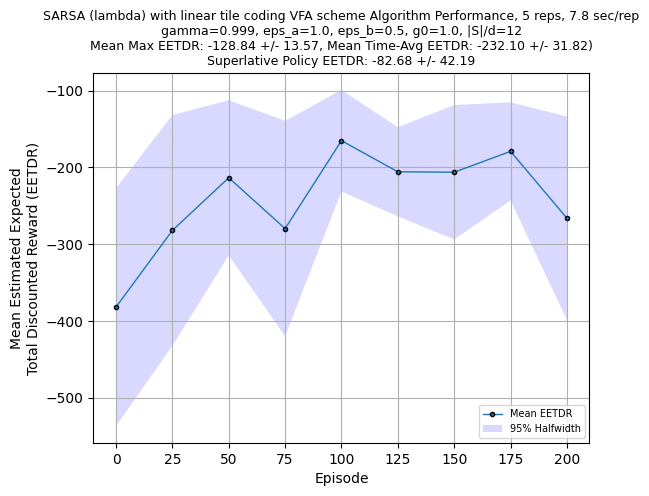


Best VFA (1st) test... EETDR CI: -121.5 +/- 30.2

Best VFA (2nd) test... EETDR CI:  -82.7 +/- 42.2

Best VFA (3rd) test... EETDR CI: -119.7 +/- 68.3

Best VFA (4th) test... EETDR CI: -134.7 +/- 54.4

Best VFA (5th) test... EETDR CI: -174.7 +/- 25.6

Best VFA (6th) test... EETDR CI: -146.1 +/- 43.8

Best VFA (7th) test... EETDR CI: -147.9 +/- 60.5

Best VFA (8th) test... EETDR CI: -153.2 +/- 52.1

Best VFA (9th) test... EETDR CI: -135.9 +/- 37.3

Best VFA (10th) test... EETDR CI: -132.1 +/- 37.8


AssertionError: 394 (<class 'numpy.int64'>) invalid 

: 

In [1]:
from LambdaSARSA import LambdaSARSA
import gymnasium as gym

env = gym.make('LunarLander-v2')
lam_sarsa = LambdaSARSA(env)
lam_sarsa.train(num_replications=5, num_episodes=200)
lam_sarsa.get_results()
lam_sarsa.show_results()
lam_sarsa.display_best_policy()

In [ ]:
!rm -r __pycache__/
import wandb

sweep_config = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "Score"},
    'parameters': {
        'alpha_a': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'alpha_b': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'eps_a': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'eps_b': {'distribution': 'uniform', 'min': 0, 'max': 1},
        'eta': {'distribution': 'log_uniform', 'min': 1e-7, 'max': 1e-5},
        'n_batch_size': {'distribution': 'log_uniform', 'min': 2**8, 'max': 2**10},
    }
}

#wandb.init(project="DSOR 646 - Final")
sweep_id = wandb.sweep(sweep=sweep_config, project="my-first-sweep")

import gymnasium as gym
env = gym.make('MountainCar-v0')

def main():
    run = wandb.init()
    model = LSPI(env,
        alpha_a = wandb.config.alpha_a,
        alpha_b = wandb.config.alpha_b,
        eps_a = wandb.config.eps_a,
        eps_b = wandb.config.eps_b,
        eta = wandb.config.eta,
        n_batch_size = wandb.config.n_batch_size
        )
    model.train(num_replications=10,num_episodes=300)
    maxETDR, maxETDRhw, meanMaxTestEETDR, maxTestHW, meanAULC, hwAULC, time = model.get_results()
    alg_score = 0.6*(meanMaxTestEETDR-maxTestHW) + 0.4*(meanAULC-hwAULC)
    wandb.log({
            "maxETDR": maxETDR,
            "maxETDRhw": maxETDRhw,
            "meanMaxTestEETDR": meanMaxTestEETDR,
            "maxTestHW": maxTestHW,
            "meanAULC": meanAULC,
            "hwAULC": hwAULC,
            "time": time,
            "Score": alg_score
        })

# Start sweep job.
wandb.agent(sweep_id, function=main, count=5)